In [1]:
import networkx as nx
import pandas
from hatchet import *
import os
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import platform
import json
from ast import literal_eval as make_tuple
import matplotlib.cm as cm
import mpld3
import random
import utils
from logger import log
from functools import wraps
import time
import numpy as np

/Users/jarus/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/jarus/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/jarus/miniconda3/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
from state import State
import utils

In [3]:
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

In [4]:
dirname = "/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/"
# dirname = "/Users/padmanabanke1/CallFlow/.callflow"
# dirname = "/home/vidi/Work/llnl/CallFlow/.callflow"

In [5]:
class Create:
    '''
    Creates a graph frame.
    Input : config variable, and dataset name
    Output : State object containing components of graphframe as separate object variables. 
    '''
    def __init__(self, config, name):
        utils.debug("Creating graphframes: ", name)
        self.config = config
        self.name = name
        self.run()

    def run(self):
        dirname = "/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/"
        callflow_path = os.path.abspath(dirname)
        data_path = os.path.abspath(os.path.join(callflow_path, self.config['paths'][self.name]))

        gf = GraphFrame()
#         if self.config.format[self.name] == 'hpctoolkit':
        gf.from_hpctoolkit(data_path)
#         elif self.config.format[self.name] == 'caliper':                
#             gf.from_caliper(data_path)  

        self.gf = gf
        self.df = gf.dataframe
        self.node_hash_map = utils.node_hash_mapper(self.df)    
        self.graph = gf.graph

In [6]:
def create(name):
    state = State()
    create = Create(config, name)

    state.entire_gf = create.gf
    state.entire_df = create.df
    state.entire_graph = create.graph
        
        # print("After Creating.")
        # print(state.df.groupby(['module']).mean())
    return state

In [7]:
class Filter:
    '''
    Filter the graphframe.
    Input: State object, parameter to filterBy (could be inclusive/exclusive, 
            filterPerc: user provided filter percentage (1-100))
    '''
    def __init__(self, state, filterBy, filterPerc):
        utils.debug('filter By:', filterBy)
        utils.debug('filter Perc:', filterPerc)
        self.state = state
        self.graph = state.entire_graph
        self.df = state.entire_df
        self.gf = state.entire_gf

        self.df.set_index(['node', 'rank'], drop=False, inplace=True)

        # self.df = pd.MultiIndex.from_frame(self.df, names=['node', 'rank'])
        self.gf.dataframe = self.df
        
        self.filterBy = filterBy
        self.filterPercInDecimals = int(filterPerc)/100
        # self.filterPercInDecimals = 0.0001 
        
        self.fgf = self.run() 
        log.info("Modules: {0}".format(self.fgf.dataframe['module'].unique()))
        
        # update df and graph after filtering.
        self.df = self.fgf.dataframe
        self.graph = self.fgf.graph
    
    def lookup(self, df, node):
        return df.loc[df['name'] == node.callpath[-1]]
    
    def getMaxExcTime_from_gf(self, graph, dataframe):
        ret = float(dataframe['time'].max())
        return ret

    def getMaxIncTime_from_gf(self, graph, dataframe):
        ret = 0.0
        for root in graph.roots:
            node_df = self.lookup(dataframe, root)
            ret = max(ret, float(max(node_df['time (inc)'].tolist())))
        return ret

    def run(self):
        log.info('Filtering the graph.')
        t = time.time()
        if self.filterBy == "Inclusive":
            max_inclusive_time = self.getMaxIncTime_from_gf(self.graph, self.df)
            filter_gf = self.gf.filter(lambda x: True if(x['time (inc)'] > self.filterPercInDecimals*max_inclusive_time) else False)
        elif filterBy == "Exclusive":
            max_exclusive_time = self.getMaxExcTime_from_gf(self.graph, self.df)
            log.info('[Filter] By Exclusive time = {0})'.format(max_exclusive_time))
            filter_gf = self.gf.filter(lambda x: True if (x['time'] > self.filterPercInDecimals*max_exclusive_time) else False)
        else:
            log.warn("Not filtering.... Can take forever. Thou were warned")
            filter_gf = self.gf
        
        log.info('[Filter] Removed {0} rows. (time={1})'.format(self.gf.dataframe.shape[0] - filter_gf.dataframe.shape[0], time.time() - t))

        return filter_gf

    def graft(self):
        log.info("Squashing the graph.")
        t = time.time()
        fgf = squash(self.fgf)
        old_new_id_mapping = self.fgf.squash()[1]
        log.info("[Squash] {1} rows in dataframe (time={0})".format(time.time() - t, fgf.dataframe.shape[0]))
        return fgf

In [8]:
def filter(state, filterBy, filterPerc):
    filter_obj = Filter(state, filterBy, filterPerc)

    state.gf = filter_obj.gf
    state.df = filter_obj.df
    state.graph = filter_obj.graph

    return state

In [9]:
def tmp_wrap(func):
    @wraps(func)
    def tmp(*args, **kwargs):
        log.info("Preprocessing : {0}".format(func.__name__))
        return func(*args, **kwargs)
    return tmp

# Preprocess the dataframe
# Builder object
# Preprocess.add_X().add_Y().....
class PreProcess():
    def __init__(self, builder):
        self.graph = builder.graph
        self.df = builder.df
        self.gf = builder.gf

    def map(self):
        return self.map

    class Builder(object):
        def __init__(self, state, gf_type='filter'):
            self.state = state
            if(gf_type == 'filter'):
                self.gf = state.gf
                self.df = state.df
                self.graph = state.graph
            elif(gf_type  == 'entire'):
                self.gf = state.entire_gf
                self.df = state.entire_df
                self.graph = state.entire_graph
            self.map = {}
            # self.df_index_name_map = self.bfs()
        
        def bfs(self):
            ret = {}
            node_count = 0
            root = self.graph.roots[0]
            node_gen = self.graph.roots[0].traverse()
            try:
                while root.callpath != None:
                    node_count += 1
                    root = next(node_gen)
                    ret[root.callpath[-1]] = root.df_index
            except StopIteration:
                pass
            finally:
                print("Total nodes in the graph", node_count)
                del root
            return ret
            
        def build(self):
            return PreProcess(self)

        # Add the path information from the node object
        @tmp_wrap
        def add_path(self):
            self.df['path'] = self.df['node'].apply(lambda node: node.callpath)
            return self

        def _map(self, attr, ):
            ret = {}
            for idx, row in self.df.iterrows():
                node_df = self.state.lookup_with_node(row.node)
                n_index = node_df['n_index'].tolist()
                p_incTime  = node_df[attr].tolist()
                for idx in range(len(n_index)):
                    if n_index[idx] not in ret:
                        ret[n_index[idx]] = []
                    ret[n_index[idx]].append(p_incTime[idx])
            return ret

        @tmp_wrap
        def add_incTime(self):
            self.map['time (inc)'] = self._map('time (inc)')
            return self

        @tmp_wrap
        def add_excTime(self):
            self.map['time'] = self._map('time')
            return self

        # Max of the inclusive Runtimes among all processes
        # node -> max([ inclusive times of process])
        @tmp_wrap
        def add_max_incTime(self):
            ret = {}

            for idx, row in self.df.iterrows():
                ret[str(row.nid)] = max(self.state.lookup(row.nid)['time (inc)'])

            self.map['max_incTime'] = ret
            self.df['max_incTime'] = self.df['node'].apply(lambda node: self.map['max_incTime'][str(node.nid)])
            return self

        # Avg of inclusive Runtimes among all processes
        # node -> avg([ inclusive times of process])
        @tmp_wrap
        def add_avg_incTime(self):
            ret = {}
            for idx, row in self.df.iterrows():
                ret[str(row.nid)] = utils.avg(self.state.lookup(row.nid)['time (inc)'])

            self.map['avg_incTime'] = ret    
            self.df['avg_incTime'] = self.df['node'].apply(lambda node: self.map['avg_incTime'][str(node.nid)])

            return self
        
        # Imbalance percentage Series in the dataframe    
        @tmp_wrap
        def add_imbalance_perc(self):
            ret = {}
            for idx, row in self.df.iterrows():
                max_incTime = self.map['max_incTime'][str(row.nid)]
                if(max_incTime == 0.0):
                    max_incTime = 1.0
                ret[str(row.nid)] = (self.map['max_incTime'][str(row.nid)] - self.map['avg_incTime'][str(row.nid)])/max_incTime

            self.map['imbalance_perc'] = ret
            self.df['imbalance_perc'] = self.df['node'].apply(lambda node: self.map['imbalance_perc'][str(node.nid)])
            return self
            
        @tmp_wrap
        def add_callers_and_callees(self):
            graph = self.graph
            callees = {}
            callers = {}
            module = {}
            
            root = graph.roots[0]
            node_gen = graph.roots[0].traverse()

            root_df = root.callpath[-1]
            callers[root_df] = []
            callees[root_df] = []
            
            try:
                while root.callpath != None:
                    root = next(node_gen)
                    if root.parents:
                        for idx, parent in enumerate(root.parents):
                            root_df = root.callpath[-1]
                            parent_df = parent.callpath[-1]
                            if parent_df not in callees:
                                callees[parent_df] = []
                    
                            callees[parent_df].append(root_df)

                            if root_df not in callers:
                                callers[root_df] = []
                            callers[root_df].append(parent_df)
                        
            except StopIteration:
                pass
            finally:
                del root

            self.df['callees'] = self.df['name'].apply(lambda node: callees[node] if node in callees else [])
            self.df['callers'] = self.df['name'].apply(lambda node: callers[node] if node in callers else [])        
            
            return self
        
        @tmp_wrap
        def add_show_node(self):
            self.map['show_node'] = {}
            self.df['show_node'] = self.df['node'].apply(lambda node: True)
            return self

        @tmp_wrap
        def update_show_node(self, show_node_map):
            self.map.show_node = show_node_map
            self.df['show_node'] = self.df['node'].apply(lambda node: show_node_map[str(node.df_index)])

        # node_name is different from name in dataframe. So creating a copy of it.
        @tmp_wrap
        def add_vis_node_name(self):
            self.df['vis_node_name'] = self.df['name'].apply(lambda name: name)
            return self

        @tmp_wrap
        def update_node_name(self, node_name_map):
            self.df['node_name'] = self.df['name'].apply(lambda name: node_name_map[name])
    
        @tmp_wrap
        def update_module_name(self):
            self.df['module'] = self.df['module'].apply(lambda name: utils.sanitizeName(name))
            return self
        
        @tmp_wrap
        def add_n_index(self):
            self.df['n_index'] = self.df.groupby('nid').ngroup()
            return self

        @tmp_wrap
        def add_mod_index(self):
            self.df['mod_index'] = self.df.groupby('module').ngroup()
            return self

In [10]:
 def process(state, gf_type):        
        # Pre-process the dataframe and Graph. 
        preprocess = PreProcess.Builder(state, gf_type) \
            .add_n_index() \
            .add_mod_index() \
            .add_callers_and_callees() \
            .add_show_node() \
            .add_vis_node_name() \
            .update_module_name() \
            .add_path() \
            .build()

        state.gf = preprocess.gf
        state.df = preprocess.df
        state.graph = preprocess.graph

        return state

In [11]:
def squash(graph, dataframe):
        """ Squash the graph after a filtering operation on the graphframe.
        """        
        exc_metrics = ['time']
        inc_metrics = ['time (inc)']
        global squ_idx
        num_nodes = len(graph)
        print("Number of nodes in the graph", num_nodes)

        # calculate number of unique nodes in the dataframe
        # and a set of filtered nodes
        dataframe.index.names = ['node', 'rank']
        # self.dataframe.rename(index=['node_index', 'rank_index'])

        if 'rank' in dataframe.index.names:
            num_rows_df = dataframe.groupby(['name'])
            filtered_nodes = num_rows_df.groups.keys()
        else:
            num_rows_df = len(dataframe.index)
            filtered_nodes = dataframe.index

        node_clone = {}
        old_to_new_id = {}

        # function to connect a node to the nearest descendants that are in the
        # list of filtered nodes
        def rewire_tree(node, clone, is_root, roots):
            global squ_idx

            cur_children = node.children
            new_children = []

            # iteratively go over the children of a node
            while(cur_children):
                for child in cur_children:
                    cur_children.remove(child)
                    if child.callpath[-1] in filtered_nodes:
                        new_children.append(child)
                    else:
                        for grandchild in child.children:
                            cur_children.append(grandchild)

            label_to_new_child = {}
            if node.callpath[-1] in filtered_nodes:
                # create new clones  for each child in new_children and rewire
                # with this node
                for new_child in new_children:
                    node_label = new_child.callpath[-1]
                    if node_label not in label_to_new_child.keys():
                        new_child_callpath = list(clone.callpath)
                        new_child_callpath.append(new_child.callpath[-1])

                        new_child_clone = Node(new_child.nid, tuple(new_child_callpath), clone)
                        idx = squ_idx
                        squ_idx += 1
                        clone.add_child(new_child_clone)
                        label_to_new_child[node_label] = new_child_clone
                    else:
                        new_child_clone = label_to_new_child[node_label]
                        idx = new_child_clone.nid

                    node_clone[new_child] = new_child_clone
                    old_to_new_id[new_child.nid] = idx
                    rewire_tree(new_child, new_child_clone, False, roots)
            elif is_root:
                # if we reach here, this root is not in the graph anymore
                # make all its nearest descendants roots in the new graph
                for new_child in new_children:
                    new_child_clone = Node(new_child.nid, tuple([new_child.callpath[-1]]), None)
                    node_clone[new_child] = new_child_clone
                    old_to_new_id[new_child.nid] = squ_idx
                    squ_idx += 1
                    roots.append(new_child_clone)
                    rewire_tree(new_child, new_child_clone, False, roots)

        squ_idx = 0

        new_roots = []
        # only do a squash if a filtering operation has been applied
        if num_nodes != num_rows_df:
            for root in graph.roots:
                if root.callpath[-1] in filtered_nodes:
                    clone = Node(root.nid, (root.callpath[-1],), None)
                    new_roots.append(clone)
                    node_clone[root] = clone
                    old_to_new_id[root.nid] = squ_idx
                    squ_idx += 1
                    rewire_tree(root, clone, True, new_roots)
                else:
                    rewire_tree(root, None, True, new_roots)

        print(old_to_new_id)
        # create new dataframe that cloned nodes
        new_dataframe = dataframe.copy()
        new_dataframe['old_nid'] = new_dataframe['nid'].apply(lambda x: x)
        new_dataframe['node'] = new_dataframe['node'].apply(lambda x: node_clone[x])
#         new_dataframe['nid'] = new_dataframe['nid'].apply(lambda x: old_to_new_id[x])
        # new_dataframe.reset_index(level='node', inplace=True, drop=True)
        # create dict that stores aggregation function for each column
        agg_dict = {}
        for col in new_dataframe.columns.tolist():
            if col in exc_metrics + inc_metrics:
                agg_dict[col] = numpy.sum
            else:
                agg_dict[col] = lambda x: x.iloc[0]

        # perform a groupby to merge nodes with the same callpath
        index_names = ['node', 'rank']
        # agg_df = new_dataframe.groupby(index_names).agg(agg_dict)
        agg_df = new_dataframe
        new_graphframe = GraphFrame(Graph(new_roots), agg_df)
        new_graphframe.exc_metrics = exc_metrics
        new_graphframe.inc_metrics = inc_metrics
        new_graphframe.update_inclusive_columns()

        return [new_graphframe, old_to_new_id]

In [12]:
def graft(df, graph):
    log.info("Squashing the graph.")
    t = time.time()
    squash_obj = squash(graph, df)[0]

    state = State()
    state.gf = squash_obj
    state.df = squash_obj.dataframe
    state.graph = squash_obj.graph

#     old_new_id_mapping =gf.squash()[1]
    log.info("[Squash] {1} rows in dataframe (time={0})".format(time.time() - t, state.df.shape[0]))
    return state

In [13]:
def trees_to_literal(graph, dataframe):
    """ Calls to_json in turn for each tree in the graph/forest
    """
    literal = []
    nodes = dataframe['name'].unique()
    adj_idx_map = {}
    for idx, node in enumerate(nodes):
        adj_idx_map[node] = idx

    num_of_nodes = len(nodes)
    adj_matrix = np.zeros(shape=(num_of_nodes, num_of_nodes))

    mapper = {}
    print(dataframe[['nid','old_nid']])

    def add_nodes_and_children(hnode):
        if 'old_nid' in dataframe.columns:
            print('function name: {0}, id: {1}'.format(hnode.callpath[-1], hnode.nid))
            node_df = dataframe.loc[(dataframe['name'] == hnode.callpath[-1]) & (dataframe['nid'] == str(hnode.nid))]
            print(node_df)
            node_id = node_df['nid'].unique()
            if(len(node_id) != 0):
                node_id = node_id[0]
            else:
                node_id = -1
                
        else:
            node_df = dataframe.loc[(dataframe['nid'] == hnode.nid)]
            node_id = node_df['nid'].unique()[0]
        node_name = hnode.callpath[-1]
        children = []
        
        for child in hnode.children:
            # print(type(child), child.callpath[-1])
            child_df = dataframe.loc[dataframe['name'] == child.callpath[-1]]
            # print(child_df['name'].unique())
            child_name = child_df['name'].unique()[0]
            if child_name in adj_idx_map and node_name in adj_idx_map:
                source_idx = adj_idx_map[node_name]
                target_idx = adj_idx_map[child_name]
                if(adj_matrix[source_idx][target_idx] == 0.0):
                    adj_matrix[source_idx, target_idx] = 1.0                
            children.append(add_nodes_and_children(child))

        return {
            "name": node_name,
            "children": children,
            "nid": int(node_id),
            "metrics": { 
                # "time (inc)": node_df['time (inc)'].tolist(),
                # "time": node_df['time'].tolist(),
            }
        }

    print("Roots:", graph.roots)
    for root in graph.roots:
        literal.append(add_nodes_and_children(root))
    print(literal)
    return literal

In [14]:
def write_gf(state, state_name, format_of_df, write_graph=True):
        dirname = "/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow"
        utils.debug('writing file for {0} format'.format(format_of_df))

        if write_graph:
            # dump the entire_graph as literal
            graph_literal = trees_to_literal(graph=state.graph, dataframe=state.df)
            graph_filepath = dirname + '/' + state_name + '/' + format_of_df + '_graph.json'
            utils.debug('File path: {0}'.format(graph_filepath))
            with open(graph_filepath, 'w') as graphFile:
                json.dump(graph_literal, graphFile)

        # dump the filtered dataframe to csv.
        df_filepath = dirname + '/' + state_name + '/' + format_of_df + '_df.csv'
        state.df.to_csv(df_filepath)

In [26]:
dataset_name = 'kripke-impi'
config = {
    'paths': {
        'kripke-impi': './data/kripke/mvapich2',
    }
}
# dataset_name = 'calc-pi'
# config = {
#     'paths': {
#         'calc-pi': './data/hpctoolkit-cpi-database',
#     }
# }
state = create(dataset_name)
state = process(state, 'entire')
# dfs(calc_state.graph, 100)
# write_gf(state, dataset_name, 'entire')

 CallFlow:   [callfow.py] Action: Creating graphframes:  "kripke-impi"


Times:
    fill tables:         0.00s
    read metric db:      0.18s
    graph construction:  7.86s
    data frame:          0.36s



 CallFlow:  Preprocessing : add_n_index
 CallFlow:  Preprocessing : add_mod_index
 CallFlow:  Preprocessing : add_callers_and_callees
 CallFlow:  Preprocessing : add_show_node
 CallFlow:  Preprocessing : add_vis_node_name
 CallFlow:  Preprocessing : update_module_name
 CallFlow:  Preprocessing : add_path


In [27]:
filterBy = 'Inclusive'
filterPerc = 1.0
filter_state = filter(state, filterBy, filterPerc) 
# self.write_gf(state, dataset_name, 'filter')

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1.0
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 294525 rows. (time=35.3374080657959)
 CallFlow:  Modules: ['libmonitor.so.0.0.0' 'kripke' 'Unknown(NA)' 'libc-2.17.so'
 CallFlow:   'libmpi.so.12.0.5']


In [28]:
graft_state = graft(filter_state.df, filter_state.graph)

 CallFlow:  Squashing the graph.


Number of nodes in the graph 2339
{6: 0, 8: 1, 538: 2, 639: 3, 641: 4, 642: 5, 653: 6, 654: 7, 655: 8, 656: 9, 657: 10, 658: 11, 659: 12, 660: 13, 643: 653, 645: 14, 798: 15, 799: 16, 825: 17, 905: 799, 2133: 18, 2148: 2133, 1836: 19, 1837: 20, 910: 21, 1059: 22, 1061: 23, 1062: 24, 1063: 25, 1066: 26, 1067: 27, 1793: 28, 1794: 29, 1694: 1066, 1634: 1066, 1798: 30, 1797: 31, 1839: 32, 1840: 33, 1841: 34, 1842: 35, 1843: 36, 1844: 37, 1845: 38, 1846: 39, 1847: 40, 1848: 41, 1849: 42, 2139: 2133, 1863: 1836, 1887: 1836, 2917: 43, 2918: 44, 724: 2917, 2157: 45, 2159: 46, 2161: 47, 2163: 48, 2165: 49, 2167: 50, 2169: 51, 2171: 52, 2173: 53, 2526: 54, 2527: 55, 2528: 56, 2529: 57, 2530: 58, 2531: 59, 2532: 60, 744: 2917, 745: 61, 746: 62, 747: 63, 671: 2917, 691: 64, 692: 65, 693: 66, 695: 67, 703: 68, 704: 69, 705: 70, 706: 71, 707: 72, 708: 73, 709: 74, 710: 75, 711: 76, 712: 77, 749: 78, 750: 79, 751: 80, 753: 81, 767: 82, 768: 83, 769: 84, 770: 85, 771: 86, 772: 87, 33: 88, 35: 89, 37: 

 CallFlow:  [Squash] 5251 rows in dataframe (time=0.5767233371734619)


In [29]:
write_gf(graft_state, dataset_name, 'filter')

 CallFlow:   [callfow.py] Action: writing file for filter format 


                                                  nid  old_nid
node                                       rank               
<program root>                             0        6        6
                                           1        6        6
                                           2        6        6
                                           3        6        6
                                           4        6        6
...                                               ...      ...
1969:MPIR_Reduce_index_tuned_intra_MV2     64    2165     2165
1894:MPIR_Reduce_inter_knomial_wrapper_MV2 64    2167     2167
1096:MPIR_Reduce_knomial_MV2               64    2169     2169
1014:PMPI_Waitany                          64    2171     2171
200:psm_progress_wait                      64    2173     2173

[5251 rows x 2 columns]
Roots: [<hatchet.node.Node object at 0x1a16437c50>]
function name: <program root>, id: 6
Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, 

Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path, old_nid]
Index: []
function name: Loop@<unknown file> [kripke]:0, id: 2917
Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path, old_nid]
Index: []
function name: <unknown file> [kripke]:0, id: 2918
Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path, old_nid]
Index: []
function name: Loop@<unknown file> [kripke]:0, id: 745
Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path, old_nid]
Index: []
function name: Loop@<unknown file> [kripke]:0, id: 746
Empty DataFrame
Columns: [time (inc), time, nid, rank, 

Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path, old_nid]
Index: []
function name: 1263:MPIR_Reduce_impl, id: 35
Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path, old_nid]
Index: []
function name: 1081:MPIR_Reduce_MV2, id: 37
Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path, old_nid]
Index: []
function name: 1969:MPIR_Reduce_index_tuned_intra_MV2, id: 39
Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path, old_nid]
Index: []
function name: 1894:MPIR_Reduce_inter_knomial_wrapper_MV2, id: 41
Empty DataFrame
Columns: [time (inc), time, nid, rank, 

 CallFlow:   [callfow.py] Action: File path: /Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow/kripke-impi/filter_graph.json 


Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path, old_nid]
Index: []
[{'name': '<program root>', 'children': [{'name': 'main', 'children': [{'name': 'SweepSolver', 'children': [{'name': 'Loop@<unknown file> [kripke]:0', 'children': [{'name': 'Kernel_3d_DGZ::LTimes', 'children': [{'name': '<unknown file> [kripke]:0', 'children': [], 'nid': -1, 'metrics': {}}, {'name': 'Loop@<unknown file> [kripke]:0', 'children': [{'name': '<unknown file> [kripke]:0', 'children': [], 'nid': -1, 'metrics': {}}, {'name': 'Loop@<unknown file> [kripke]:0', 'children': [{'name': '<unknown file> [kripke]:0', 'children': [], 'nid': -1, 'metrics': {}}, {'name': 'Loop@<unknown file> [kripke]:0', 'children': [{'name': '<unknown file> [kripke]:0', 'children': [], 'nid': -1, 'metrics': {}}, {'name': 'Loop@<unknown file> [kripke]:0', 'children': [{'name': '<unknown file> [kripke]:0', 'children': [], 'nid'

In [30]:
def dfs(graph, limit):
    def dfs_recurse(root):
        level = 0
        for node in root.children:
            if(level < limit):
                print('Node =', node)
                level += 1
                dfs_recurse(node)
        
    for root in graph.roots:
        print("Root = ", root)
        dfs_recurse(root)

In [31]:
print(filter_state.df.loc[filter_state.df['nid'] == '20'])

Empty DataFrame
Columns: [time (inc), time, nid, rank, name, type, file, line, module, node, n_index, mod_index, callees, callers, show_node, vis_node_name, path]
Index: []


In [33]:
dfs(graft_state.graph, 100)

Root =  <program root>
Node = main
Node = SweepSolver
Node = Loop@<unknown file> [kripke]:0
Node = Kernel_3d_DGZ::LTimes
Node = <unknown file> [kripke]:0
Node = Loop@<unknown file> [kripke]:0
Node = <unknown file> [kripke]:0
Node = Loop@<unknown file> [kripke]:0
Node = <unknown file> [kripke]:0
Node = Loop@<unknown file> [kripke]:0
Node = <unknown file> [kripke]:0
Node = Loop@<unknown file> [kripke]:0
Node = <unknown file> [kripke]:0
Node = __memset_sse2
Node = SweepSubdomains
Node = Loop@<unknown file> [kripke]:0
Node = Loop@<unknown file> [kripke]:0
Node = __memset_sse2
Node = Loop@<unknown file> [kripke]:0
Node = <unknown file> [kripke]:0
Node = <unknown file> [kripke]:0
Node = SweepComm::readySubdomains
Node = ParallelComm::testRecieves
Node = <unknown file> [kripke]:0
Node = Loop@<unknown file> [kripke]:0
Node = <unknown file> [kripke]:0
Node = PMPI_Testany
Node = Loop@<unknown file> [kripke]:0
Node = <unknown file> [kripke]:0
Node = Loop@<unknown file> [kripke]:0
Node = <unknown 

In [36]:
# entire_df = graft_state.entire_df
df = graft_state.df

In [37]:
# entire_df_modules = state.entire_df['module'].unique()
# print("Modules in entire_df:", entire_df_modules)
print('\n')
df_modules = state.df['module'].unique()
print("Modules in df:", df_modules)



Modules in df: ['libmonitor.so.0.0.0' 'kripke' 'Unknown(NA)' 'libc-2.17.so'
 'libmpi.so.12.0.5']


In [38]:
def number_of_functions(df, module):
    module_df = df.loc[df['module'] == module]
    number_of_functions_df = module_df.groupby(['name', 'nid'])
    print("Number of functions in {0}: {1} ".format(module, number_of_functions_df.ngroups))

In [ ]:
print("Functions inside the entire_df \n")
for module in entire_df_modules:
    number_of_functions(df, module)

In [39]:
print("Functions inside the df \n")
for module in df_modules:
    number_of_functions(df, module)

Functions inside the df 

Number of functions in libmonitor.so.0.0.0: 1 
Number of functions in kripke: 10 
Number of functions in Unknown(NA): 28 
Number of functions in libc-2.17.so: 2 
Number of functions in libmpi.so.12.0.5: 9 


In [40]:
def plot_metric(df, module, metric):
    module_df = df.loc[df['module'] == module]
    print('Module:', module)
    inclusive_entire_df = module_df.groupby(['name', 'nid'])[metric]
    number_of_functions = inclusive_entire_df.ngroups
    print("Number of functions inside:", number_of_functions)
    grid_length = math.floor(math.sqrt(number_of_functions))
    print(grid_length)
    if number_of_functions != 1:
        f, ax = plt.subplots(grid_length+1, grid_length+1,  sharey=True)
    idx = 0
    for name, group in inclusive_entire_df:
        div_idx = math.floor(idx / grid_length)
        mod_idx = math.floor(idx % grid_length)
        print(name)
#         print(group)
        ax[div_idx, mod_idx].hist(group)
        ax[div_idx, mod_idx].set_title(name[0:4])
        idx += 1

Module: kripke
Number of functions inside: 10
3
('Grid_Data::particleEdit', 2157)
('Kernel_3d_DGZ::LPlusTimes', 749)
('Kernel_3d_DGZ::LTimes', 641)
('Kernel_3d_DGZ::scattering', 691)
('Kernel_3d_DGZ::sweep', 1839)
('ParallelComm::testRecieves', 1061)
('SweepComm::readySubdomains', 1059)
('SweepSolver', 538)
('SweepSubdomains', 798)
('main', 8)


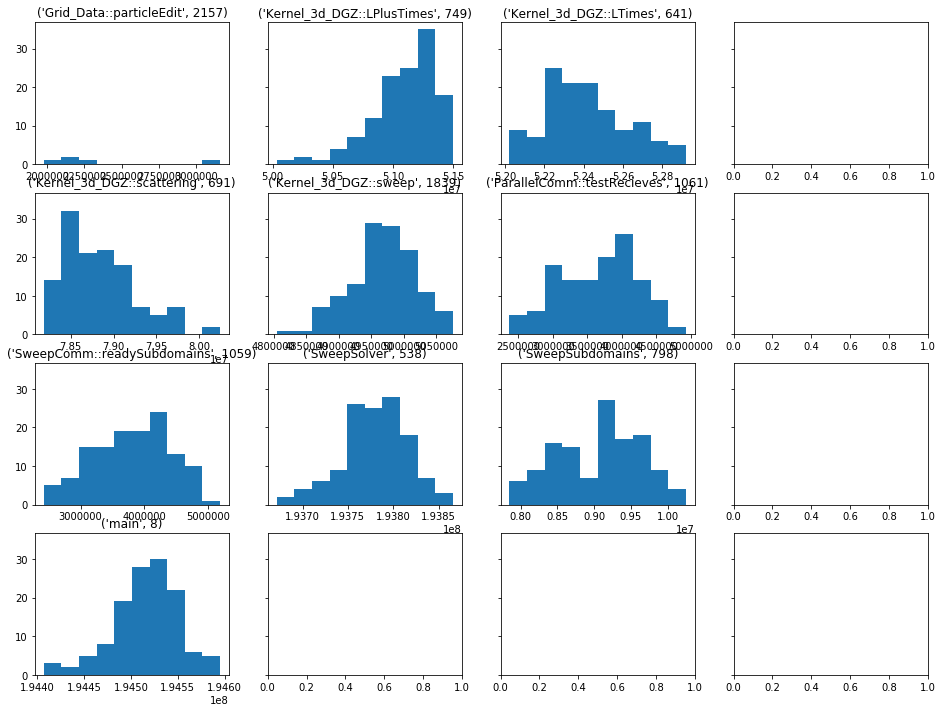

In [41]:
plot_metric(df, df_modules[1], 'time (inc)')

Module: Unknown(NA)
Number of functions inside: 28
5
('<unknown file> [kripke]:0', 660)
('<unknown file> [kripke]:0', 710)
('<unknown file> [kripke]:0', 712)
('<unknown file> [kripke]:0', 772)
('<unknown file> [kripke]:0', 1849)
('Loop@<unknown file> [kripke]:0', 639)
('Loop@<unknown file> [kripke]:0', 643)
('Loop@<unknown file> [kripke]:0', 653)
('Loop@<unknown file> [kripke]:0', 655)
('Loop@<unknown file> [kripke]:0', 657)
('Loop@<unknown file> [kripke]:0', 659)
('Loop@<unknown file> [kripke]:0', 693)
('Loop@<unknown file> [kripke]:0', 703)
('Loop@<unknown file> [kripke]:0', 705)
('Loop@<unknown file> [kripke]:0', 707)
('Loop@<unknown file> [kripke]:0', 709)
('Loop@<unknown file> [kripke]:0', 711)
('Loop@<unknown file> [kripke]:0', 751)
('Loop@<unknown file> [kripke]:0', 767)
('Loop@<unknown file> [kripke]:0', 769)
('Loop@<unknown file> [kripke]:0', 771)
('Loop@<unknown file> [kripke]:0', 905)
('Loop@<unknown file> [kripke]:0', 1063)
('Loop@<unknown file> [kripke]:0', 1841)
('Loop@<u

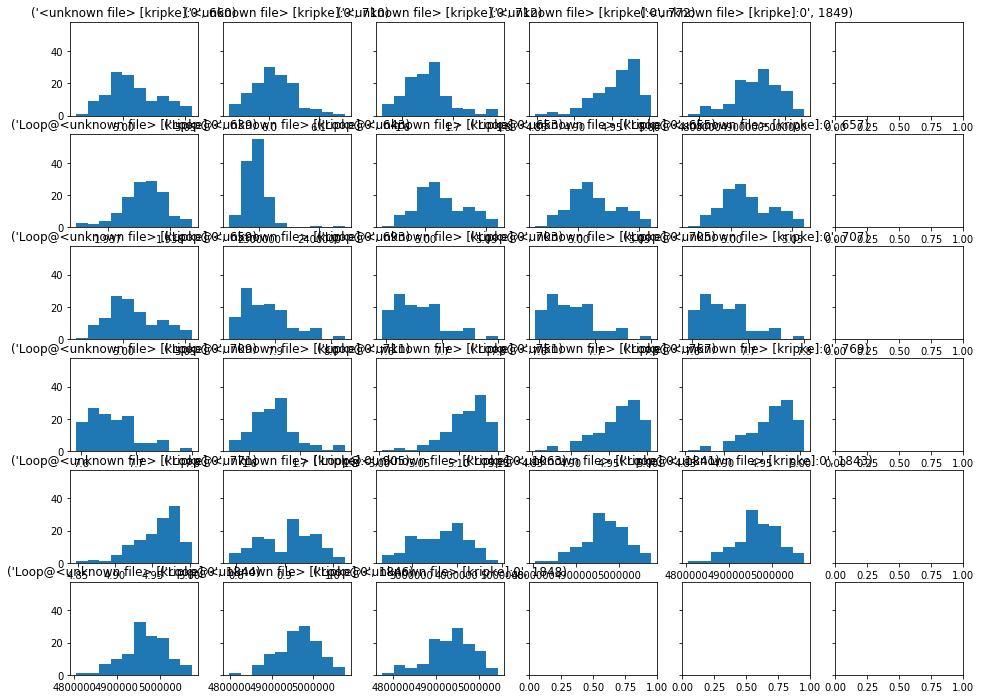

In [42]:
plot_metric(df, df_modules[2], 'time (inc)')

Module: libmpi.so.12.0.5
Number of functions inside: 9
3
('1014:PMPI_Waitany', 2171)
('1081:MPIR_Reduce_MV2', 2163)
('1096:MPIR_Reduce_knomial_MV2', 2169)
('1263:MPIR_Reduce_impl', 2161)
('1894:MPIR_Reduce_inter_knomial_wrapper_MV2', 2167)
('1969:MPIR_Reduce_index_tuned_intra_MV2', 2165)
('200:psm_progress_wait', 2173)
('PMPI_Reduce', 2159)
('PMPI_Testany', 1067)


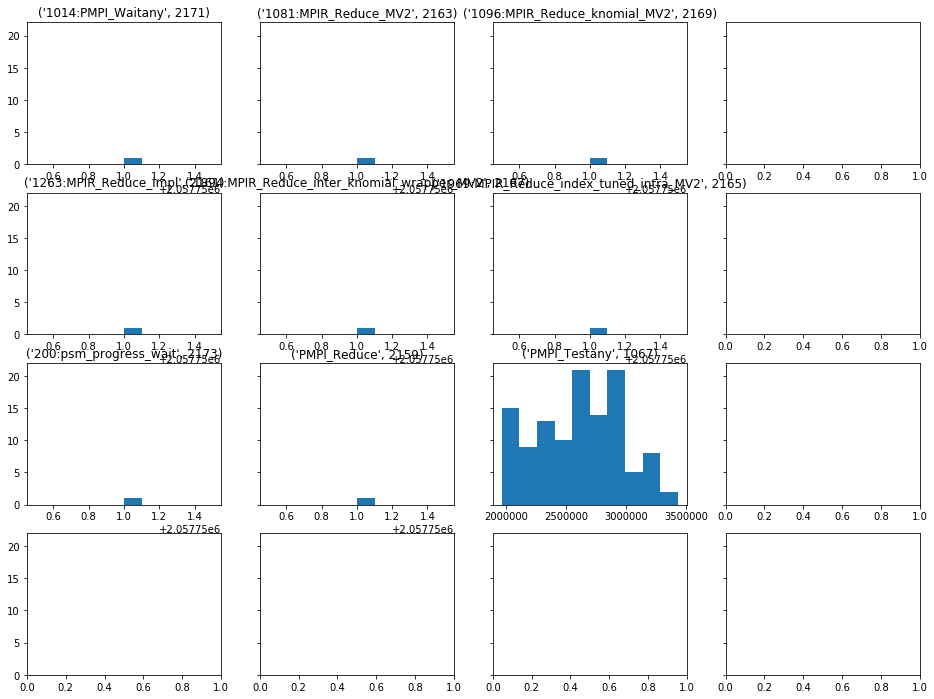

In [43]:
plot_metric(df, df_modules[4], 'time (inc)')